w的L2范数： 0.36832866072654724


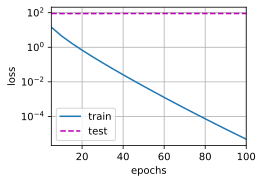

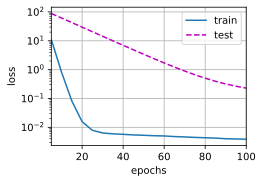

In [3]:
import math
import numpy as np
import torch
from torch import nn
from tools import tool_pytorch_017 as ty

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = ty.synthetic_data(true_w, true_b, n_train)
train_iter = ty.load_array(train_data, batch_size)
test_data = ty.synthetic_data(true_w, true_b, n_test)
test_iter = ty.load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    ''' L2 范数实现 '''
    return torch.sum(w.pow(2)) / 2

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: ty.linreg(X, w, b), ty.squared_loss
    num_epochs, lr = 100, 0.003
    animator = ty.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            ty.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (ty.evaluate_loss(net, train_iter, loss),
                                     ty.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = ty.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (ty.evaluate_loss(net, train_iter, loss),
                          ty.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())
    
train(lambd=0)

train_concise(3)